In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (12,7)

In [116]:
stuff=np.load('./sidebands.npz')
t=stuff['time']
d=stuff['signal']

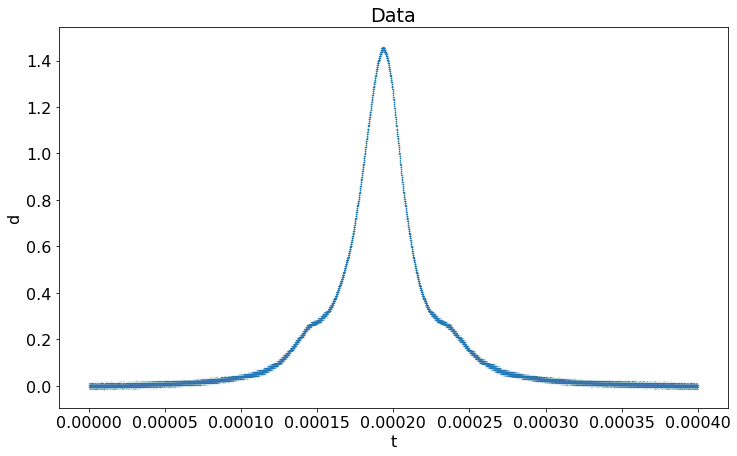

In [117]:
plt.plot(t, d, '.', ms=0.1)
plt.xlabel('t')
plt.ylabel('d')
plt.title('Data')
plt.show()

## Part a)

For the first part of this lab, I will model the data with Newton's method using a single lorenztian and analytic derivatives for the gradient. The function I am fitting is:

$$d = \frac{a}{1 - (t-t_0)^2/w^2}$$

Where $a$ = amplitude, $t_0$ = center, and $w$ = width.

For the gradient, I had the following components for each of the parameters:

$$\frac{\partial{A}}{\partial{a}} = \frac{1}{1 - (t-t_0)^2/w^2}$$

$$\frac{\partial{A}}{\partial{t_0}} = \frac{2aw^2(t-t_0)^2}{((t-t_0)^2 + w^2)^2}$$

$$\frac{\partial{A}}{\partial{w}} = \frac{2aw(t_0-t)^2}{((t_0-t)^2 + w^2)^2}$$

After performing the fit the best fit parameters were as follows:

$$a = 1.422810666682028$$
$$t_0 = 1.9235864929418168 \times 10^{-4}$$
$$w = 1.7923691145805102 \times 10^{-5}$$

The figure below shows the resulting model fit from these parameters. Even though we see that the general shape is quite similar, the sidebands are completely ignored as we expect from using a single lorentzian. In addition, I notice that the fit is also quite poor near the top of the main peak at the center, where the model seems to underestimate the height by some amount. Due to the misfit of the sidebands, the ends of the fit are also quite poor compared to the sides of the main peak, for example.

In [4]:
def lorentzian_analytic(p, t):
    '''estimates the lorentzian and gradient of lorentzian for set of parameters p'''
    a = p[0]
    t0 = p[1]
    w = p[2]
    
    # model
    y = a / (1 + (t-t0)**2/w**2)
    
    # getting analytic derivatives wrt to each parameter
    grad = np.zeros([t.size, p.size])
    grad[:,0] = 1 / (1 + (t-t0)**2/w**2)
    grad[:,1] = 2*a*w**2*(t-t0) / ((t-t0)**2 + w**2)**2
    grad[:,2] = 2*a*w*(t0-t)**2 / ((t0-t)**2 + w**2)**2
    
    return y, grad

In [5]:
# starting guess based on plot of data
p0 = np.array([1.4, 0.0002, 0.0001])

# performing newton's method
p = p0.copy()
for j in range(10):
    pred, grad = lorentzian_analytic(p, t)
    r = d - pred
    r = np.matrix(r).transpose()
    grad = np.matrix(grad)

    lhs = grad.transpose() @ grad
    rhs = grad.transpose() @ r
    dp = np.linalg.inv(lhs) @ rhs
    for jj in range(p.size):
        p[jj] = p[jj] + dp[jj]

In [6]:
print('Best fit parameters are, a = {}, t_0 = {}, w = {}'.format(p[0], p[1], p[2]))

Best fit parameters are, a = 1.422810666682028, t_0 = 0.00019235864929418168, w = 1.7923691145805102e-05


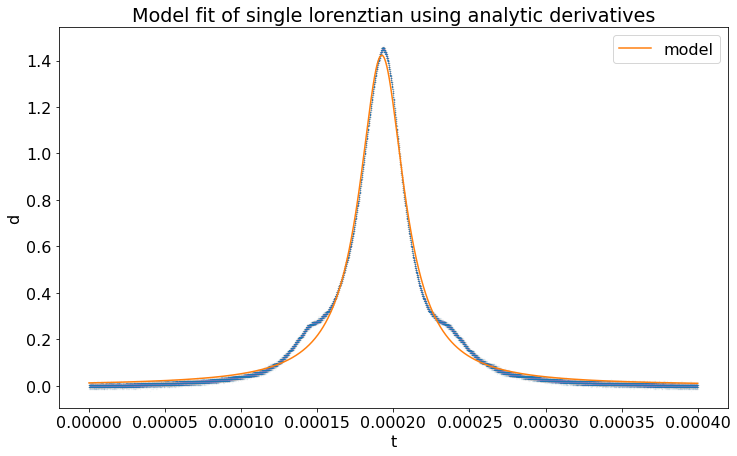

In [7]:
ypred, _ = lorentzian_analytic(p, t)
plt.plot(t, d, '.', ms=0.1, alpha=0.3)
plt.plot(t, ypred, label='model')
plt.xlabel('t')
plt.ylabel('d')
plt.title('Model fit of single lorenztian using analytic derivatives')
plt.legend()
plt.show()

## Part b)

To estimate the noise in the data, I looked the residuals and and took the mean of the the residuals squared. We can see in the plot below that the residuals are definitely not gaussian distributed around 0, so this estimate is to be taken with a grain of salt. We see that estimating the error in this way is not extremely accurate as the places where the single lorentzian has the worst fit contributes to what we are estimating to be the instrinsic noise of the data. However, this was the best I could do given I didn't know ahead of time what the noise would be based on the instruments and measurements. With this, I got an estimate of the noise in the data to be characterized by: $$\sigma^2 \approx 0.000637$$

Then, I generated the noise matrix $N$ and took the analytic inverse to estimate the covariance matrix using 

$$var = (A^TN^{-1}A)^{-1}$$

Where $A$ is the matrix with the gradient of the lorentzian model with respect to the parameters.

Then, by taking the squareroot of the diagonal elements of this covariance matrix, I got the estimate for the errors in each of the parameters, which turned out as follows:

$$\delta a = 4.25478995 \times 10^{-4}$$
$$ \delta t_0 = 5.35834685 \times 10^{-9}$$
$$\delta w = 7.58809907 \times 10^{-9}$$

In [8]:
# getting residuals
res_analytical = ypred - d

# estimating noise in the data
sig2 = np.mean(res_analytical**2)
print('the noise in data is = {}'.format(sig2))

# creating noise matrix
N_elements = np.array([sig2] * len(d))

# getting the inverse analytically
Ninv = np.diag(1/N_elements)

# getting covariance matrix and parameter errors
var = np.linalg.inv(grad.transpose() @ Ninv @ grad)
err_params = np.sqrt(np.diag(var))
print()
print('errors in the parameters [a, t0, w] are respectively ')
print(err_params)

the noise in data is = 0.0006367266230717475

errors in the parameters [a, t0, w] are respectively 
[4.25478995e-04 5.35834685e-09 7.58809907e-09]


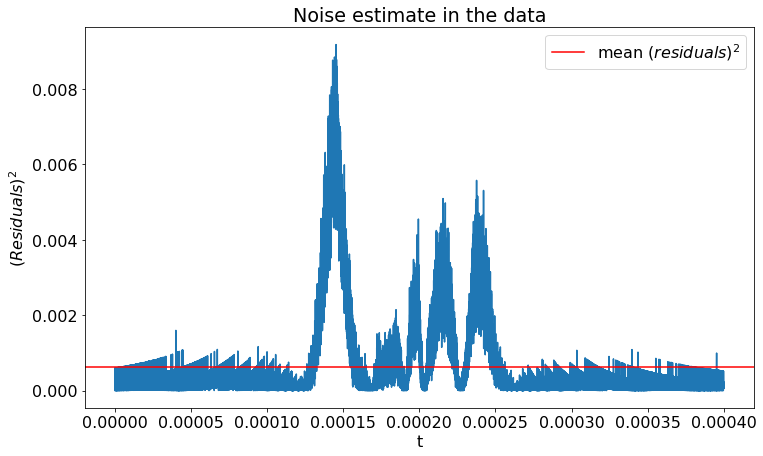

In [9]:
plt.plot(t, res_analytical**2)
plt.axhline(sig2, color='red', label='mean $(residuals)^2$')
plt.title('Noise estimate in the data')
plt.legend()
plt.xlabel('t')
plt.ylabel(r'$(Residuals)^2$')
plt.show()

## Part c)

For this part, I repeated the fit of the single lorentzian but using numerical derivatives instead of analytic derivatives for the gradient of A. I used the get_model_derivs and get_model_derivs_ravel functions from Jon's code in order to get those derivatives and format the matrices properly. We see that very similar to using the analytic derivatives, our estimates for the parameters are:

$$a = 1.42281407 \pm  4.25483331 \times 10^{-4}  $$
$$t_0 = 1.92358632\times 10^{-4}\pm 5.35824954\times 10^{-9}$$
$$w =   1.79236053 \times 10^{-5} \pm 7.58796100\times 10^{-9}$$

Now, if we compare the mean and the standard deviation of the residuals of both the methods using numerical or analytic derivatives, we see that they are very close to each other. Therefore we can say that there is no statistically significant difference between using the numerical or analytical derivative when using newton's method to perform a model fit. This is great because it assures us that we can use numerical derivatives when trying to fit a model that doesn't have easily found analytic derivatives.

In [10]:
def lorentzian(p, t):
    '''single lorentzian'''
    a = p[0]
    t0 = p[1]
    w = p[2]
    return a / (1 + (t-t0)**2/w**2)

In [30]:
def get_model_derivs(fun, pars, dpar, t):
    '''general function to get derivatives from model 
       - from Jon\'s code'''
    model = fun(pars, t)
    npar = len(pars)
    derivs = [None]*npar
    
    # getting derivative with respect to each parameter
    for i in range(npar):
        pp = pars.copy()
        # forward shift
        pp[i] = pars[i] + dpar[i]
        m_plus = fun(pp,t)
        # backward shift
        pp[i] = pars[i] - dpar[i]
        m_minus = fun(pp,t)
        # actually finding derivative with central difference
        derivs[i] = (m_plus - m_minus)/(2*dpar[i])
    return model, derivs

def get_model_derivs_ravel(fun, pars, dpar, t):
    '''reshapes the model and derivatives keeping the right order for future manipulation
       - from Jon\'s code'''
    model, derivs = get_model_derivs(fun, pars, dpar, t)
    model = np.ravel(model)
    npar = len(pars)
    derivs_out = np.empty([len(model), len(pars)])
    for i in range(npar):
        derivs_out[:,i] = np.ravel(derivs[i])
    return model, derivs_out

def newton(pars, data, fun, t, dpar, niter=20):
    '''performs the nonlinear fit using newtons method'''
    for i in range(niter):
        model, derivs = get_model_derivs_ravel(fun, pars, dpar, t)
        r = data - model
        lhs = derivs.T @ derivs
        rhs = derivs.T @ r
        dpar = np.linalg.inv(lhs) @ rhs
        pars = pars + dpar
    
    # estimating noise in the data
    sig2 = np.mean(r**2)

    # creating noise matrix
    N_elements = np.array([sig2] * len(data))

    # getting the inverse analytically
    Ninv = np.diag(1/N_elements)
    
    return pars, Ninv, derivs

def get_covar(Ninv, derivs):
    '''get covariance matrix and parameter errors'''  
    # covariance matrix and errors in parameters
    var = np.linalg.inv(derivs.transpose() @ Ninv @ derivs)
    err_params = np.sqrt(np.diag(var))
    
    return var, err_params

In [31]:
# starting guess and starting shift size
pars = np.array([1.4, 0.0002, -0.0001])
dpar = np.asarray([0.01,0.01,0.01,0.01])/10000

In [32]:
fitp, Ninv, derivs = newton(pars, d, lorentzian, t, dpar)
mymod = lorentzian(fitp, t)

In [33]:
fitp

array([1.42281068e+00, 1.92358649e-04, 1.79236908e-05])

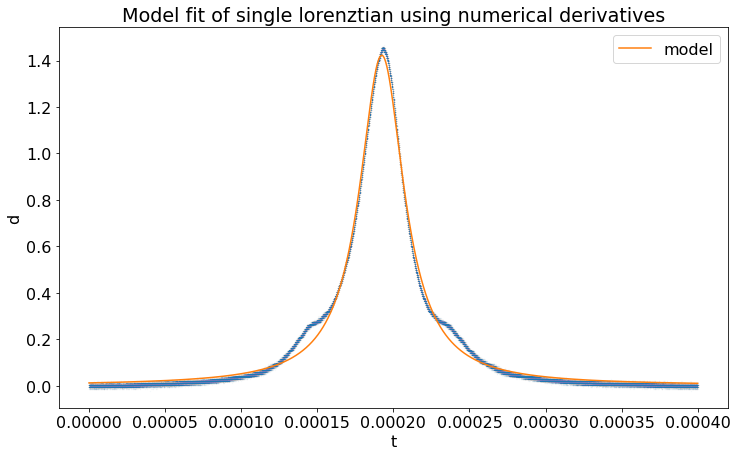

In [34]:
plt.plot(t, d, '.', ms=0.1, alpha=0.3)
plt.plot(t, mymod, label='model')
plt.xlabel('t')
plt.ylabel('d')
plt.title('Model fit of single lorenztian using numerical derivatives')
plt.legend()
plt.show()

In [35]:
print('parameters [a, t0, w] are respectively ')
print(fitp)

parameters [a, t0, w] are respectively 
[1.42281068e+00 1.92358649e-04 1.79236908e-05]


In [36]:
res_numerical = mymod - d
print('comparing the statistics of the model with analytic and numerical derivatives')
print('     --------------------------------------------------------')
print('     std of residuals', np.std(res_numerical), np.std(res_analytical))
print('     means of residuals', np.mean(np.abs(res_numerical)), np.mean(np.abs(res_analytical)))

comparing the statistics of the model with analytic and numerical derivatives
     --------------------------------------------------------
     std of residuals 0.025044391795394815 0.025044391587947117
     means of residuals 0.019352836455178636 0.01935283693396756


## Part d)

Now we repeat the process of fitting but instead of fitting one lorentzian to the data, we create a model of 3 lorentzians of varying amplitude and center. The model to fit is given by:

$$d = \frac{a}{1 - (t-t_0)^2/w^2} + \frac{b}{1 - (t-t_0+dt)^2/w^2} + \frac{c}{1 - (t-t_0-dt)^2/w^2}$$

I generated a guess for the $a, t_0, w$ parameters by looking at the previous fits. For the new parameters $b, c, dt$, I did some trials with plotting the model for sensible values of them and converged on what I assumed to be sensible values for them based on the shape of the data and the model.

After performing the fit, the estimated best fit parameters with their errors are given by:


$$a = 1.44299223 \pm  2.66429589 \times 10^{-4}  $$
$$b = 0.103910491 \pm 2.54120391\times 10^{-4}$$
$$c = 0.0647315702 \pm 2.48827081\times 10^{-4}$$
$$t_0 = 1.92578527 \times 10^{-4} \pm  3.15440813 \times 10^{-9}  $$
$$w = 1.60651288 \times 10^{-5}\pm 5.64931126\times 10^{-9}$$
$$dt =   4.45673765 \times 10^{-5} \pm 3.80260836\times 10^{-8}$$

The model fit using these parameters is shown in the plot below. Comparing to the fit of the single lorentzian, we see that there is a good amount of improvement in the regions with the sidebands, which were completely ignored previously. However, we still see that the fit at the top of the main peak and at the very far sides is far from perfect. 

We see that the errors for our parameters are on similar scales to what we had when using the single lorentzian. This is a bit surprising to me since we have a fit that looks much better. 

In [37]:
def lorentzian_add(p, t):
    
    a = p[0]
    b = p[1]
    c = p[2]
    t0 = p[3]
    w = p[4]
    dt = p[5]
    
    return (a / (1 + (t-t0)**2/w**2)) + (b / (1 + (t-t0+dt)**2/w**2)) + (c / (1 + (t-t0-dt)**2/w**2))

In [38]:
pars_add = np.array([1.4, 0.1, 0.1, 0.0002, 0.00002, 0.00005])
dpar_add = np.asarray([0.01, 0.01, 0.01, 0.01, 0.01, 0.01])/1000
fitp_add, Ninv_add, derivs_add = newton(pars_add, d, lorentzian_add, t, dpar_add)
varp_add, errp_add = get_covar(Ninv_add, derivs_add)

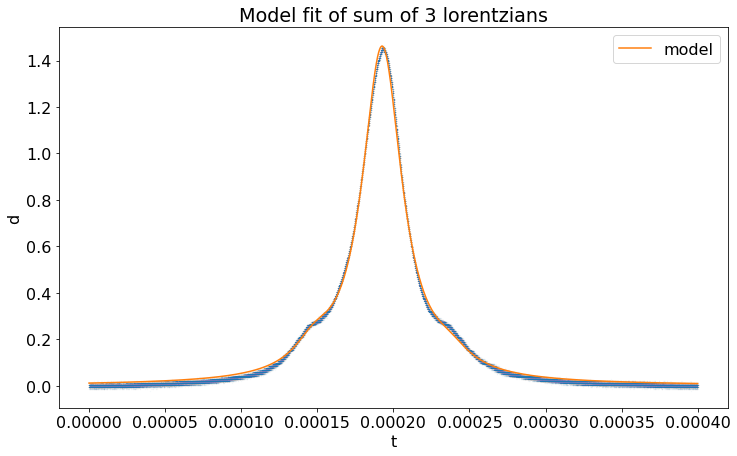

In [39]:
mymod_add = lorentzian_add(fitp_add, t)

plt.plot(t, d, '.', ms=0.1, alpha=0.3)
plt.plot(t, mymod_add, label='model')
plt.xlabel('t')
plt.ylabel('d')
plt.title('Model fit of sum of 3 lorentzians')
plt.legend()
plt.show()

In [40]:
print('parameters [a, b, c, t0, w, dt] are respectively ')
print(fitp_add)
print()
print('errors in the parameters [a, b, c, t0, w, dt] are respectively ')
print(errp_add)

parameters [a, b, c, t0, w, dt] are respectively 
[1.44299239e+00 1.03910783e-01 6.47325298e-02 1.92578522e-04
 1.60651094e-05 4.45671634e-05]

errors in the parameters [a, b, c, t0, w, dt] are respectively 
[2.66429037e-04 2.54116772e-04 2.48823333e-04 3.15443711e-09
 5.64926865e-09 3.80268481e-08]


## Part e)

Now we examine the residuals of our fits. I did this for both the fit with the single Lorentzian and the fit with the sum of the 3 lorentzians. Both of the residuals are shown in the plots below. The first thing I noticed is that they both have very distinct patterns and shapes that deviate far from what we would get if the error was uniformly distributed. This makes me believe that both of these models do not fully encompass the data. Looking at the residuals makes me think the error bars have been underestimated by assuming that the data is independent and have uniform variance. Clearly there is some correlation between the data points and the noise is not uniform at all times. The current model is definitely not a complete description of the data.

However, when comparing the residuals for the first fit and the second fit, we see that the latter performs better. We can see that the residuals in the regions corresponding to the secondary peaks are much smaller with the second fit, which makes sense. The overall residuals are also more compactly concentrated around 0 and do not span as wide as did the ones for the first fit. Finally, we see that including the 3 lorentzians in the model did improve the fit, as both the standard deviation and mean of the residual decreased compared to the single lorentzian model.

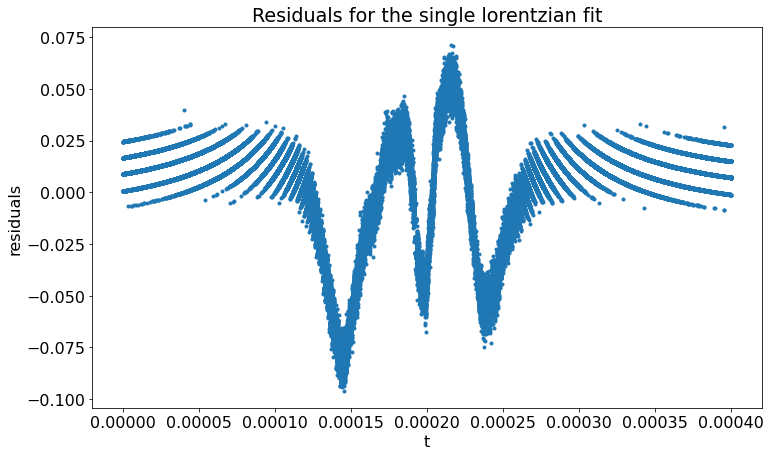

In [43]:
plt.plot(t, res_numerical, '.')
plt.xlabel('t')
plt.ylabel('residuals')
plt.title('Residuals for the single lorentzian fit')
plt.show()

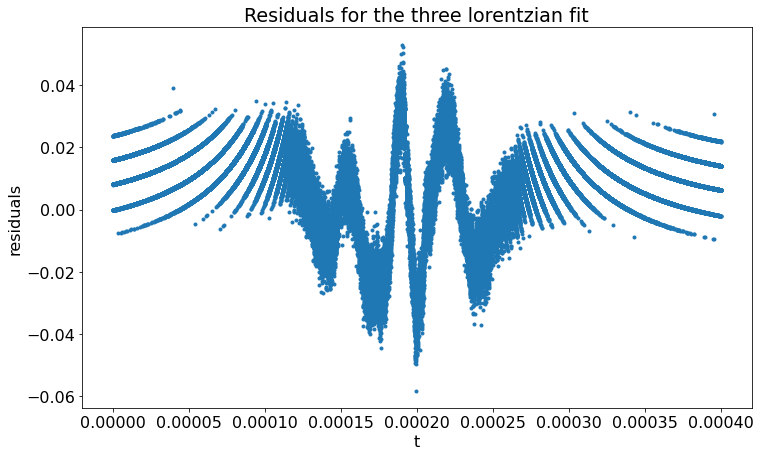

In [44]:
res_add = mymod_add - d
plt.plot(t, res_add, '.')
plt.title('Residuals for the three lorentzian fit')
plt.xlabel('t')
plt.ylabel('residuals')
plt.show()

In [45]:
print('comparing the statistics of the model with single lorentzian')
print('     --------------------------------------------------------')
print('     std ----- single', np.std(res_numerical), '--------- sum', np.std(res_add))
print('     means --- single', np.mean(np.abs(res_numerical)), '--------- sum', np.mean(np.abs(res_add)))

comparing the statistics of the model with single lorentzian
     --------------------------------------------------------
     std ----- single 0.025044391795394815 --------- sum 0.012730079684715113
     means --- single 0.019352836455178636 --------- sum 0.012606329690400557


## Part f)

I generated some realizations from the covariance matrix found in part d) using $np.random.multivariate\_normal$. When inspecting my covariance matrix, I noticed that the off diagonal terms were very small. When I did this exercise with the calculated matrix, the parameters would barely vary when picked from this distribution and the $\chi^2$ would stay relatively the same. Based on the discussions we had in class/tutorials and some of the readings I did, I believe there is a mistake somewhere higher up in the code causing these values in the covariance matrix to be so small. In an attempt to not let it affect the rest of my work, I scaled up the values, but would love some help figuring out where I could have gone wrong. 

Using the results with my scaled covariance matrix, I generated models from these new disturbed parameters. The plot below shows the models overlaying the data, with the best fit model labeled as such. I zoomed in because otherwise the differences were very hard to spot. We can see in the zommed box that the different models in fact vary from the best fit but not by too much. 

By examining the $\chi^2$ of 1000 generated models from this distribution, I found that their mean was slightly higher than that of the $\chi^2$ for the model with the best fit parameters.

In [46]:
def chisq_fun(fun, params, data, t):
    '''estimates chi squared value'''
    
    pred = fun(params, t)
    chisq = np.sum((pred - data)**2)
    
    return chisq

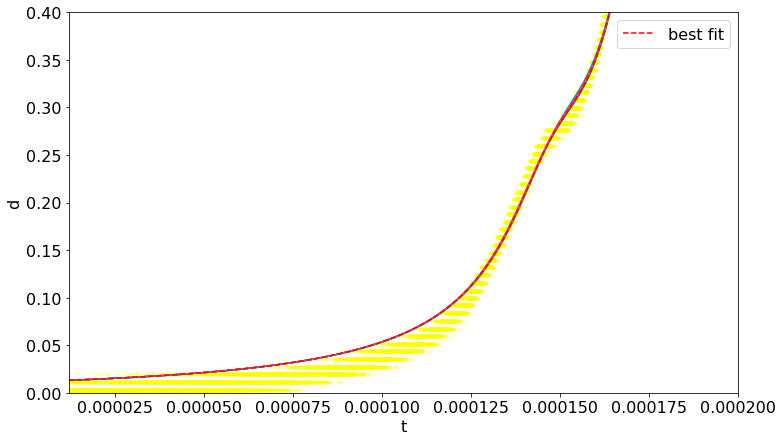

In [62]:
# generating 10 realizations of the parameters from the covariance matrix and best fit parameters
pars_deviated = np.random.multivariate_normal(fitp_add, varp_add*100, 5)
plt.plot(t, d, '.', alpha=0.1, color='yellow')

for pd in pars_deviated:
    y = lorentzian_add(pd, t)
    plt.plot(t, y)
   
plt.plot(t, mymod_add, '--', ms=10, color='red', label='best fit')
plt.xlim(0.000012, 0.00020)
plt.ylim(0, 0.4)
plt.legend()
plt.xlabel('t')
plt.ylabel('d')
plt.show()

In [63]:
# estimating the chis squared for each parameter set
pars_deviated = np.random.multivariate_normal(fitp_add, varp_add*100, 1000)
chisq_devs = []
for pd in pars_deviated:
    chisq_devs.append(chisq_fun(lorentzian_add, pd, d, t))
chisq_best = chisq_fun(lorentzian_add, fitp_add, d, t)

In [64]:
print('mean chi squared', np.mean(chisq_devs))
print('std chi squared', np.std(chisq_devs))

mean chi squared 21.379310091299054
std chi squared 0.07386279123681676


In [65]:
chisq_best

21.24727418433437

## Part g)

Now I repeated the fit using MCMC using the covariance matrix to determine the size of each trial step. The best fit parameters and their errors are given below.

$$a = 1.43683936 \pm  1.73451425 \times 10^{-2}  $$
$$b = 0.105358017 \pm 1.95828296\times 10^{-2}$$
$$c = 0.0634747673 \pm 1.64291232\times 10^{-2}$$
$$t_0 = 1.92616468 \times 10^{-4} \pm  2.24698803 \times 10^{-7}  $$
$$w = 1.61402061 \times 10^{-5}\pm 3.79422745\times 10^{-7}$$
$$dt =   4.46939394 \times 10^{-5} \pm 2.54561861\times 10^{-6}$$

While the actual parameter values are quite similar to what we got using newton's method, the errors on the parameters estimated by the MCMC are much larger and I think a better representation of their actual error, as we saw the residuals were not ideal. 

To ensure that the chain had converged, I looked the the value for each of the parameters as it changed from step to step. We can see the reulting plot below for one of the parameters. The parameter quickly changes value at the beginning but then bounces around the same values as times goes on. This represents that the chain has converged (with the given errors) ont he actual value of the parameter. A plot very similar to this can be produces for all the other parameters. 

When estimating the parameters from the mean value of this chain, I cut off the first 2000 values to avoid the effect of the "burn-in" in our parameter estimation.

In [85]:
nsteps = 20000

# initializing chain
chain = np.zeros([nsteps, len(pars_add)])

# start position
chain[0,:] = pars_add

# start chi squared
chisq = chisq_fun(lorentzian_add, chain[0,:], d, t)

no = 0
for i in range(1, nsteps):
    # take trial step from errors of gaussian approximation
    pp = chain[i-1,:] + np.random.multivariate_normal(np.zeros(len(varp_add)), varp_add*100)
    chisq2 = chisq_fun(lorentzian_add, pp, d, t)
    accept = np.exp(-0.5 * (chisq2 - chisq))
    if np.random.rand(1) < accept:
        chain[i,:] = pp
        chisq = chisq2
    else:
        no += 1
        chain[i,:] = chain[i-1,:]
    
    
# will probably have to chop off some part of it until converged - burn-in
burnin = chain.shape[0]//10
best_fit_MC = np.mean(chain[burnin:], axis=0)

# estimate errors on parameters from mcmc
errs_fit = np.std(chain[burnin:], axis=0)

In [91]:
print('parameters [a, b, c, t0, w, dt] are respectively ')
print(best_fit_MC)
print()
print('errors in the parameters [a, b, c, t0, w, dt] are respectively ')
print(errs_fit)

parameters [a, b, c, t0, w, dt] are respectively 
[1.43683936e+00 1.05358017e-01 6.34747673e-02 1.92616468e-04
 1.61402061e-05 4.46939394e-05]

errors in the parameters [a, b, c, t0, w, dt] are respectively 
[1.73451425e-02 1.95828296e-02 1.64291232e-02 2.24698803e-07
 3.79422745e-07 2.54561861e-06]


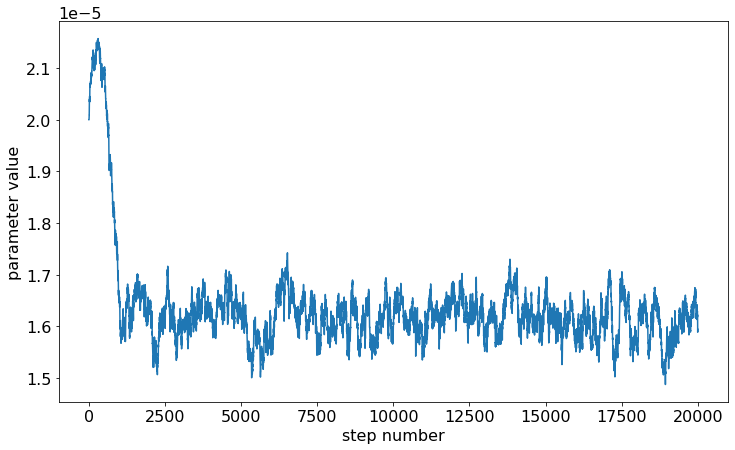

In [88]:
plt.plot(chain[:,4])
plt.ylabel('parameter value')
plt.xlabel('step number')
plt.show()

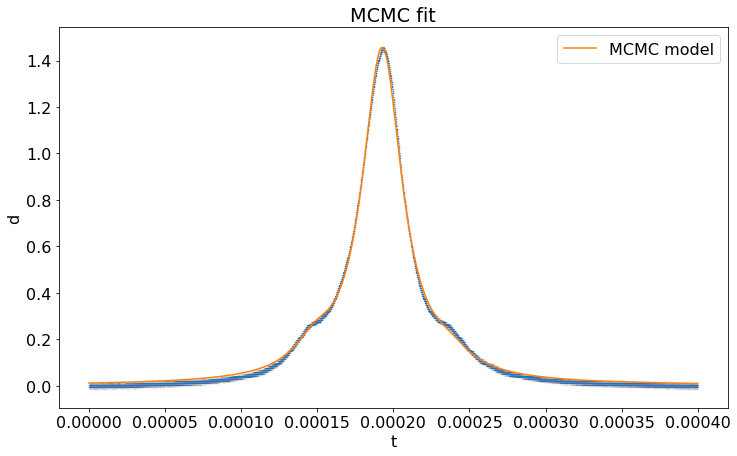

In [90]:
MCMC_mod = lorentzian_add(best_fit_MC, t)
plt.plot(t, d, '.', ms=0.1, alpha=0.3)
plt.plot(t, MCMC_mod, label='MCMC model')
plt.xlabel('t')
plt.ylabel('d')
plt.legend()
plt.title('MCMC fit')
plt.show()

## Part h)

We are told that $$dt = 9GHz$$

But from the fit, we also know that 

$$dt = 4.469393936677324 \times 10^{-5} \pm 2.545618611708212\times 10^{-6}$$

From this, we can find a relationship between the shifts in time and frequency bands. We then multiply that calculated ratio ($\frac{9}{dt({best}}$ by the best fit value of $w$ and that gives us the width of the cavity resonance in GHz. In order to estimate the error on that value, I used propagation of error and the error on the $w$ parameter. The resulting value for the actual width of the cavity resonance is:

$$w \approx 3.25 \pm 0.08 GHz$$

In [114]:
dt = best_fit_MC[-1]

# getting the relationship between shifts in the time axis and frequency width
val = 9 / dt

# projecting that onto out fitted value for the width
w = best_fit_MC[4]
width = w * val
err_width = errs_fit[4] * val

In [115]:
print('The actual width of the cavity resonance is {} +/- {} GHz'.format(width, err_width))

The actual width of the cavity resonance is 3.250146603911548 +/- 0.07640420041108467 GHz
